In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

### creating noisy layers:
y = $w(x+{\epsilon}) + b$

In [2]:
class NoisyLinear(nn.Module):
    def __init__(self, input_size, output_size, noisy_stddev=0.1):
        super().__init__()
        w = torch.Tensor(input_size, output_size)
        self.w = nn.Parameter(w)
        nn.init.xavier_uniform_(self.w)
        b = torch.Tensor(output_size).fill_(0)
        self.b = nn.Parameter(b)
        self.noisy_stddev = noisy_stddev

    def forward(self, x,training=False):
        if training:
            noise = torch.normal(0.0, self.noisy_stddev, x.shape)
            x_new = torch.add(x,noise)
        else:
            x_new = x
        return torch.add(torch.mm(x_new, self.w), self.b)



In [3]:
noisy_layer = NoisyLinear(4,2)
x = torch.zeros((1,4))

print(noisy_layer(x, training= True)) 
print(noisy_layer(x, training=True)) 
print(noisy_layer(x, training= False))

tensor([[ 0.0271, -0.0813]], grad_fn=<AddBackward0>)
tensor([[-0.2111,  0.0204]], grad_fn=<AddBackward0>)
tensor([[0., 0.]], grad_fn=<AddBackward0>)


### XOR Classification using above noisypredefined layers


In [4]:
torch.manual_seed(1)
np.random.seed(1)
x = np.random.uniform(low=-1, high=1, size=(200,2))
y = np.ones(len(x))
y[x[:, 0] * x[:,1]<0] = 0
n_train = 100
x_train = torch.tensor(x[:n_train, :], dtype=torch.float32)
y_train = torch.tensor(y[:n_train], dtype=torch.float32)
x_valid = torch.tensor(x[n_train:], dtype=torch.float32)
y_valid =  torch.tensor(y[n_train:], dtype=torch.float32)

from torch.utils.data import DataLoader, TensorDataset
batch_size=10
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size, shuffle=True)
num_epochs = 100


In [5]:
class MyNoisyModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = NoisyLinear(2,4, 0.07)
        self.a1 = nn.ReLU()
        self.l2 = nn.Linear(4,4)
        self.a2 = nn.ReLU()
        self.l3 = nn.Linear(4,1)
        self.a3 = nn.Sigmoid()

    def forward(self, x, training=False):
        x = self.l1(x)
        x = self.a1(x)
        x = self.l2(x)
        x = self.a2(x)
        x = self.l3(x)
        x = self.a3(x)
        return x
    
    def predict(self, x):
        x = torch.tensor(x, dtype=torch.float32)
        pred = self.forward(x)[:,0]
        return (pred>=0.5).float()
    
torch.manual_seed(1)
model = MyNoisyModule()
model

MyNoisyModule(
  (l1): NoisyLinear()
  (a1): ReLU()
  (l2): Linear(in_features=4, out_features=4, bias=True)
  (a2): ReLU()
  (l3): Linear(in_features=4, out_features=1, bias=True)
  (a3): Sigmoid()
)

In [6]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.015)
num_epochs = 100
loss_hist_train = [0] * num_epochs
accuracy_hist_train = [0] * num_epochs
loss_hist_valid = [0] * num_epochs
accuracy_hist_valid = [0] * num_epochs
for epoch in range(num_epochs):
    for x_batch, y_batch in train_dl:
        pred = model(x_batch)[:,0]
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_hist_train[epoch] += loss.item()
        is_correct = ((pred>=0.5).float() == y_batch).float()
        accuracy_hist_train[epoch] += is_correct.mean()
    loss_hist_train[epoch] /= n_train
    accuracy_hist_train[epoch] /= n_train/batch_size
    pred = model(x_valid)[:, 0]
    loss = loss_fn(pred, y_valid)
    loss_hist_valid[epoch] = loss.item()
    is_correct = ((pred>=0.5).float() == y_valid).float()
    accuracy_hist_valid[epoch] += is_correct.mean()


/tmp/ipykernel_605002/825903758.py:15: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  y = y_valid.numpy().astype(np.integer),


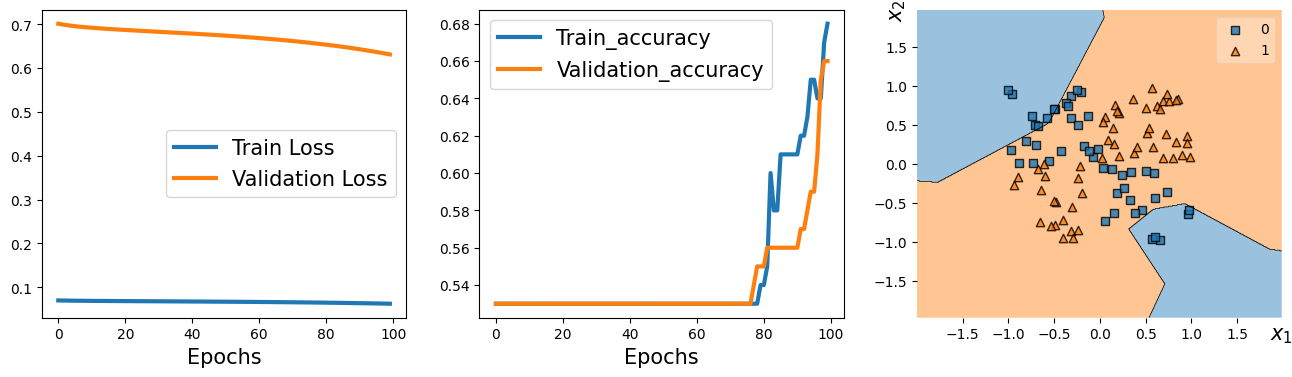

In [7]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(1,3,1)
plt.plot(loss_hist_train, lw=3)
plt.plot(loss_hist_valid, lw=3)
plt.legend(['Train Loss', 'Validation Loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)
ax = fig.add_subplot(1,3,2)
plt.plot(accuracy_hist_train, lw=3)
plt.plot(accuracy_hist_valid, lw=3)
plt.legend(['Train_accuracy', 'Validation_accuracy'], fontsize=15)
ax.set_xlabel('Epochs', size=15)
ax = fig.add_subplot(1,3,3)
from mlxtend.plotting import plot_decision_regions
plot_decision_regions(X=x_valid.numpy(),
                      y = y_valid.numpy().astype(np.integer),
                      clf=model)
ax.set_xlabel(r'$x_1$', size=15)
ax.xaxis.set_label_coords(1, -0.025)
ax.set_ylabel(r'$x_2$', size=15)
ax.yaxis.set_label_coords(-0.025, 1)
plt.show()